<a href="https://colab.research.google.com/github/Sruthij93/Stock-Price-Prediction-Sentiment-Analysis/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [1]:
!pip install supabase
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15


In [6]:
import os
from supabase import create_client
import pandas as pd
from google.colab import userdata
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

url = userdata.get("SUPABASE_URL")
key = userdata.get("SUPABASE_KEY")
alphavantage_key = userdata.get("ALPHA_VANTAGE_API_KEY")
finnhub_key = userdata.get("FINNHUB_API_KEY")
supabase = create_client(url, key)

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [165]:
# fetch data from supabase from stock_prices table and for 'AAPL' ticker
table = supabase.table("stock_prices")
response = table.select("*").eq("ticker", "AAPL").execute()


In [170]:
# convert response to dict
data = response.data
# type(data)
# convert data to df
df = pd.DataFrame(data)
df.tail(10)

,ticker,date,open,high,low,close,volume,sentiment_score,avg_sentiment,num_articles,sentiment_ma3,sentiment_lag1,log_article_count,sentiment_volatility,sentiment_close_corr
494,AAPL,2025-04-25,206.365,209.75,206.2000,209.28,38222258,None,-0.406334,47,-0.503339,-0.517044,3.871201,0.185959,0.425557
495,AAPL,2025-04-28,210.000,211.50,207.4600,210.14,38743074,None,0.000000,0,-0.307793,-0.406334,0.000000,0.236566,0.196284
496,AAPL,2025-04-29,208.693,212.24,208.3700,211.21,36827633,None,-0.512988,31,-0.306441,0.000000,3.465736,0.238439,0.459047
497,AAPL,2025-04-30,209.300,213.58,206.6705,212.50,52286454,None,-0.682777,36,-0.398588,-0.512988,3.610918,0.227561,-0.335181
498,AAPL,2025-05-01,209.080,214.56,208.9000,213.32,57365675,None,-0.412521,75,-0.536095,-0.682777,4.330733,0.218703,-0.484155
499,AAPL,2025-05-02,206.090,206.99,202.1600,205.35,101010621,None,-0.390535,85,-0.495277,-0.412521,4.454347,0.209993,-0.277814
500,AAPL,2025-05-05,203.100,204.10,198.2100,198.89,69018452,None,-0.510000,46,-0.430000,-0.390535,3.850000,0.255194,-0.240000
501,AAPL,2025-05-06,198.210,200.65,197.0200,198.51,51216482,None,-0.490000,50,-0.460000,-0.510000,3.930000,0.100000,-0.160000
502,AAPL,2025-05-07,199.170,199.44,193.2500,196.25,68616943,None,-0.720000,40,-0.570000,-0.490000,3.710000,0.130000,0.750000
503,AAPL,2025-05-08,197.720,200.05,194.6796,197.49,49072967,None,-0.410000,46,-0.540000,-0.720000,3.850000,0.130000,0.620000


In [174]:
df.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'avg_sentiment', 'num_articles', 'sentiment_ma3', 'sentiment_lag1',
       'log_article_count', 'sentiment_volatility', 'sentiment_close_corr'],
      dtype='object')

In [173]:
df.drop(columns = ['sentiment_score'], inplace=True)

In [175]:
# create a day and month column
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
# add a flag to check if there is a sentiment score or not based on num_articles
df['has_sentiment'] = df['num_articles'].apply(lambda x: 1 if x>0 else 0)

In [300]:
df.tail(5)

,ticker,date,open,high,low,close,volume,avg_sentiment,num_articles,sentiment_ma3,sentiment_lag1,log_article_count,sentiment_volatility,sentiment_close_corr,day,month,has_sentiment
499,AAPL,2025-05-02,206.09,206.99,202.1600,205.35,101010621,-0.390535,85,-0.495277,-0.412521,4.454347,0.209993,-0.277814,2,5,1
500,AAPL,2025-05-05,203.10,204.10,198.2100,198.89,69018452,-0.510000,46,-0.430000,-0.390535,3.850000,0.255194,-0.240000,5,5,1
501,AAPL,2025-05-06,198.21,200.65,197.0200,198.51,51216482,-0.490000,50,-0.460000,-0.510000,3.930000,0.100000,-0.160000,6,5,1
502,AAPL,2025-05-07,199.17,199.44,193.2500,196.25,68616943,-0.720000,40,-0.570000,-0.490000,3.710000,0.130000,0.750000,7,5,1
503,AAPL,2025-05-08,197.72,200.05,194.6796,197.49,49072967,-0.410000,46,-0.540000,-0.720000,3.850000,0.130000,0.620000,8,5,1


In [183]:
df.fillna(0, inplace=True)

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ticker                504 non-null    object        
 1   date                  504 non-null    datetime64[ns]
 2   open                  504 non-null    float64       
 3   high                  504 non-null    float64       
 4   low                   504 non-null    float64       
 5   close                 504 non-null    float64       
 6   volume                504 non-null    int64         
 7   avg_sentiment         504 non-null    float64       
 8   num_articles          504 non-null    int64         
 9   sentiment_ma3         504 non-null    float64       
 10  sentiment_lag1        504 non-null    float64       
 11  log_article_count     504 non-null    float64       
 12  sentiment_volatility  504 non-null    float64       
 13  sentiment_close_corr

## Train Two Models:
1. Using only price data
2. Using price + sentiment features

In [616]:
# features for both models
price_features = ['open', 'high', 'low', 'close', 'volume', 'day', 'month']
sentiment_features = ['avg_sentiment', 'sentiment_ma3', 'sentiment_lag1', 'log_article_count', 'sentiment_volatility', 'sentiment_close_corr', 'has_sentiment']

In [617]:
df[price_features].values.shape

(504, 7)

In [618]:
# create datasets
X_price = df[price_features].values
X_sentiment = df[price_features + sentiment_features].values

In [619]:
print(X_price.shape)
print(X_sentiment.shape)

(504, 7)
(504, 14)


In [620]:
# creating targets for next 5 days
y_multi = np.column_stack([
    df['close'].shift(-1).values,
    df['close'].shift(-2).values,
    df['close'].shift(-3).values,
    df['close'].shift(-4).values,
    df['close'].shift(-5).values
])
# fill NANs in the last 5 rows with last known close price
fill_value = df['close'].iloc[-1]
for i in range(5):
    y_multi[-5+i][-(i+1):] = fill_value

In [621]:
y_multi[-5:]

array([[198.89, 198.51, 196.25, 197.49, 197.49],
       [198.51, 196.25, 197.49, 197.49, 197.49],
       [196.25, 197.49, 197.49, 197.49, 197.49],
       [197.49, 197.49, 197.49, 197.49, 197.49],
       [197.49, 197.49, 197.49, 197.49, 197.49]])

In [622]:
# fn to create sequences for LSTM
def create_sequences(data, targets, lookback=30):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback):
        X_seq.append(data[i:i+lookback])
        y_seq.append(targets[i+lookback])
    return np.array(X_seq), np.array(y_seq)

In [623]:
# scale the data
scaler_price = MinMaxScaler()
scaler_sentiment = MinMaxScaler()
scaler_sentiment_only = MinMaxScaler()
scaler_y = MinMaxScaler()


In [624]:
# fit the scalers
X_price_scaled = scaler_price.fit_transform(X_price)
X_with_sentiment_scaled = scaler_sentiment.fit_transform(X_sentiment)
y_scaled = scaler_y.fit_transform(y_multi)
y_single_scaled = scaler_y_single.fit_transform(y_single.reshape(-1, 1))


In [625]:
# pickle dump the scalers
import pickle
with open('scaler_price.pkl', 'wb') as f:
    pickle.dump(scaler_price, f)
with open('scaler_sentiment.pkl', 'wb') as f:
    pickle.dump(scaler_sentiment, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [626]:
# create sequences of 30 days
X_price_seq, y_price_seq = create_sequences(X_price_scaled, y_scaled, lookback=30)
X_sentiment_seq, y_sentiment_seq = create_sequences(X_with_sentiment_scaled, y_scaled, lookback=30)


In [627]:
X_price_seq.shape

(474, 30, 7)

In [628]:
# split data without shuffling (80% train, 10% validation, 10% test)
total_size = len(X_price_seq)
train_end = int(total_size * 0.8)
val_end = int(total_size * 0.9)

X_price_train = X_price_seq[:train_end]
X_price_val = X_price_seq[train_end:val_end]
X_price_test = X_price_seq[val_end:]
y_price_train = y_price_seq[:train_end]
y_price_val = y_price_seq[train_end:val_end]
y_price_test = y_price_seq[val_end:]

X_sentiment_train = X_sentiment_seq[:train_end]
X_sentiment_val = X_sentiment_seq[train_end:val_end]
X_sentiment_test = X_sentiment_seq[val_end:]
y_sentiment_train = y_sentiment_seq[:train_end]
y_sentiment_val = y_sentiment_seq[train_end:val_end]
y_sentiment_test = y_sentiment_seq[val_end:]



In [629]:
X_price_train.shape

(379, 30, 7)

In [630]:
y_price_test.shape

(48, 5)

In [631]:
# Model 1: Price only model
model_price = Sequential([
    LSTM(128, return_sequences = True, input_shape = (30, X_price_train.shape[2])),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.4),
    Dense(16, activation = 'relu'),
    Dense(5)
])
model_price.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [632]:
# Model 2: With sentiment
model_with_sentiment = Sequential([
    LSTM(32, return_sequences = True, input_shape = (30, X_sentiment_train.shape[2])),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(16, activation = 'relu'),
    Dense(5)
])
model_with_sentiment.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [633]:
# early stopping to prevent overfitting and model uses best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [634]:
# Train Model 1 (price only)
print("Training price-only model: ")
history_price = model_price.fit(
    X_price_train, y_price_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)



Training price-only model: 
Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0574 - mae: 0.1843 - val_loss: 0.0502 - val_mae: 0.1873
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0209 - mae: 0.1136 - val_loss: 0.0147 - val_mae: 0.0966
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0165 - mae: 0.1011 - val_loss: 0.0175 - val_mae: 0.1039
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0118 - mae: 0.0836 - val_loss: 0.0182 - val_mae: 0.1118
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0120 - mae: 0.0838 - val_loss: 0.0167 - val_mae: 0.1070
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0116 - mae: 0.0830 - val_loss: 0.0096 - val_mae: 0.0768
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0108 - mae: 0.0807 - val_loss: 0.0105 - val_mae: 0.0807
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0098 - mae: 0.0765 - val_loss: 0.0157 - val_mae: 0.1027
Epoch 9/150
10/10 ━━━━━━━

In [635]:
# Train Model 2 (with sentiment)
print("Training model with sentiment: ")
history_sentiment = model_with_sentiment.fit(
    X_sentiment_train, y_sentiment_train,
    epochs=150,
    batch_size=32,
    validation_split = 0.2,
    callbacks=[early_stopping],
    verbose=1
)

Training model with sentiment: 
Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.1191 - mae: 0.2820 - val_loss: 0.3253 - val_mae: 0.5514
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0471 - mae: 0.1629 - val_loss: 0.0769 - val_mae: 0.2509
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0274 - mae: 0.1301 - val_loss: 0.0429 - val_mae: 0.1780
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0186 - mae: 0.1049 - val_loss: 0.0143 - val_mae: 0.0890
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0131 - mae: 0.0866 - val_loss: 0.0237 - val_mae: 0.1219
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0123 - mae: 0.0867 - val_loss: 0.0285 - val_mae: 0.1383
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0113 - mae: 0.0834 - val_loss: 0.0211 - val_mae: 0.1132
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0100 - mae: 0.0803 - val_loss: 0.0240 - val_mae: 0.1237
Epoch 9/150
10/10 ━━━━━

In [674]:
# evaluate models
price_mae = model_price.evaluate(X_price_test, y_price_test)[1]
sentiment_mae = model_with_sentiment.evaluate(X_sentiment_test, y_sentiment_test)[1]

print(f"Price-only model MAE: {price_mae:.4f}")
print(f"Sentiment model MAE: {sentiment_mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0356 - mae: 0.1487 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0334 - mae: 0.1480 
Price-only model MAE: 0.1399
Sentiment model MAE: 0.1462


In [637]:
print(f"Best validation MAE for Price model: {min(history_price.history['val_mae']):.4f}")
print(f"Best validation MAE for Sentiment model: {min(history_sentiment.history['val_mae']):.4f}")


Best validation MAE for Price model: 0.0768
Best validation MAE for Sentiment model: 0.0717


In [673]:
# function to make predictions for the next 5 days
def predict_next_5_days(model, recent, scaler_x, scaler_y):

    scaled_input = scaler_x.transform(recent)

    # reshape to get one prediction: 30 days & feature shape
    reshaped_input = scaled_input.reshape(1, 30, scaled_input.shape[1])
    print(reshaped_input.shape)

    scaled_prediction = model.predict(reshaped_input)

    # inverse transform to get actual prices
    prediction = scaler_y.inverse_transform(scaled_prediction)

    return prediction[0]

In [671]:
# last 30 days of data for prediction
latest_window_price = X_price[-30:]
latest_window_sentiment = X_sentiment[-30:]


In [640]:
latest_window_sentiment.shape

(30, 14)

In [672]:
# predict with both models
price_prediction = predict_next_5_days(model_price, latest_window_price, scaler_price, scaler_y)
sentiment_prediction = predict_next_5_days(model_with_sentiment, latest_window_sentiment, scaler_sentiment, scaler_y)


(1, 30, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 30, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [669]:
print("5 day Prediction:")
print("Day |   Price Model    | Sentiment Model")
for i in range(5):
    print(f" {i+1}  |     ${price_prediction[i]:.2f}      |     ${sentiment_prediction[i]:.2f} ")

5 day Prediction:
Day |   Price Model    | Sentiment Model
 1  |     $207.01      |     $216.43 
 2  |     $205.98      |     $216.83 
 3  |     $208.22      |     $215.83 
 4  |     $203.16      |     $216.62 
 5  |     $206.05      |     $216.88 


In [676]:
# pickle dump both models
import pickle
with open('model_price.pkl', 'wb') as f:
    pickle.dump(model_price, f)
with open('model_with_sentiment.pkl', 'wb') as f:
    pickle.dump(model_with_sentiment, f)

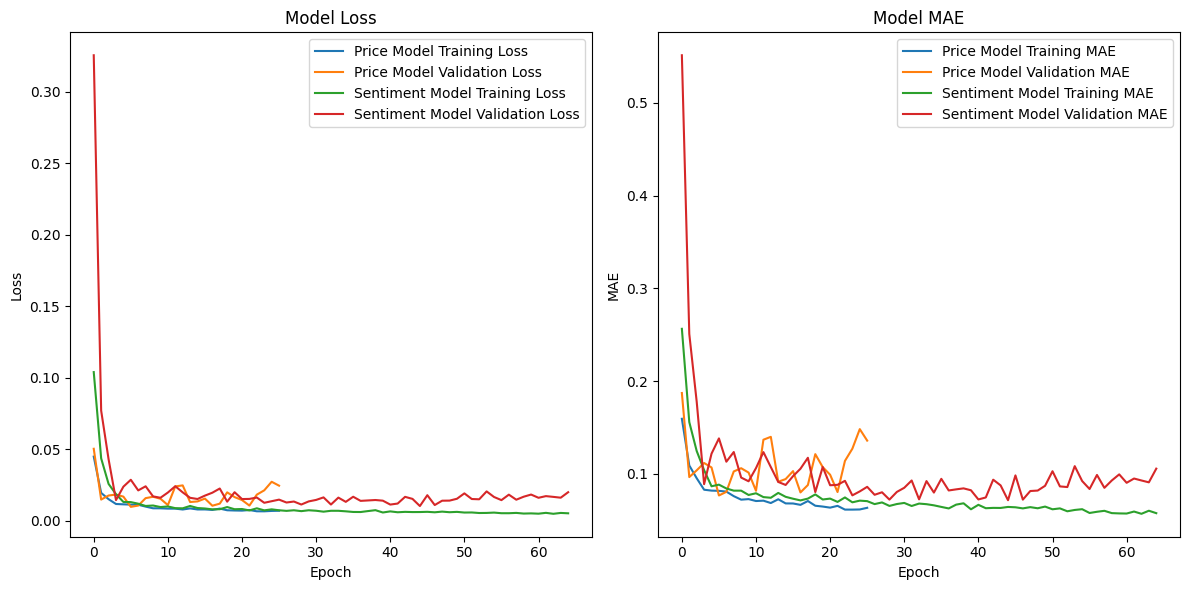

In [660]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_price.history['loss'], label='Price Model Training Loss')
plt.plot(history_price.history['val_loss'], label='Price Model Validation Loss')
plt.plot(history_sentiment.history['loss'], label='Sentiment Model Training Loss')
plt.plot(history_sentiment.history['val_loss'], label='Sentiment Model Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_price.history['mae'], label='Price Model Training MAE')
plt.plot(history_price.history['val_mae'], label='Price Model Validation MAE')
plt.plot(history_sentiment.history['mae'], label='Sentiment Model Training MAE')
plt.plot(history_sentiment.history['val_mae'], label='Sentiment Model Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


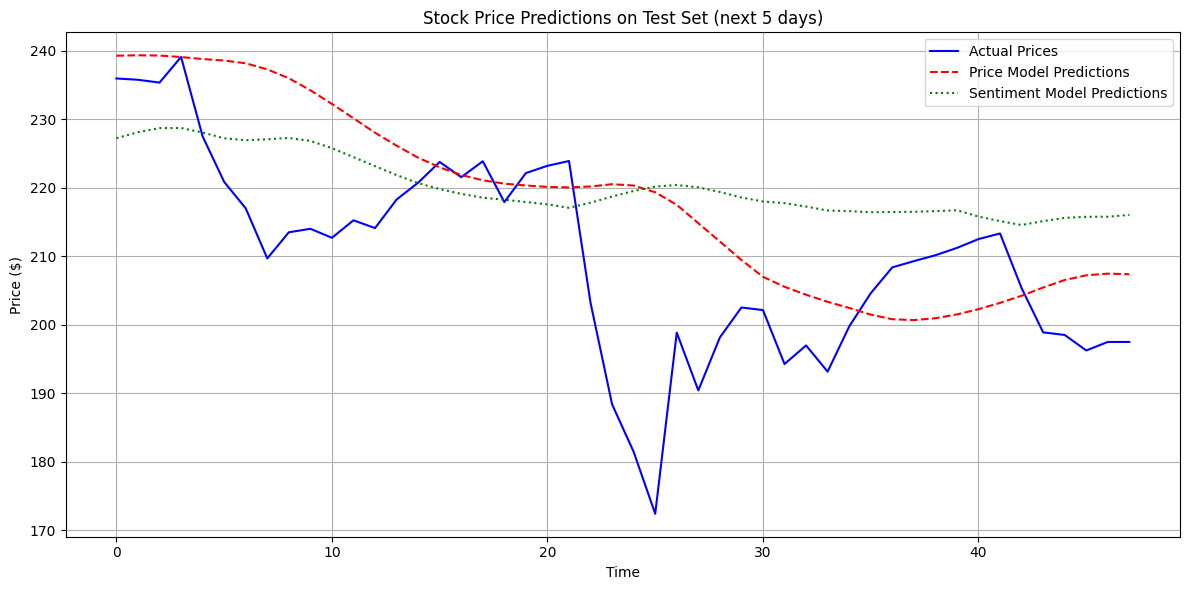

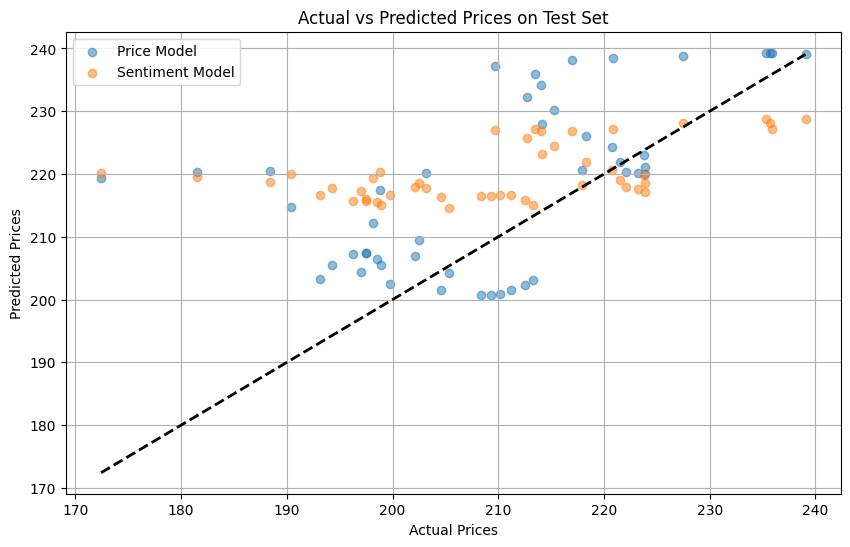

In [658]:
# Plot predictions vs actual values for the test set
plt.figure(figsize=(12, 6))
plt.title('Stock Price Predictions on Test Set (next 5 days)')
plt.xlabel('Time')
plt.ylabel('Price ($)')

# actual test set values
y_test_actual = scaler_y.inverse_transform(y_price_test)

# predictions on test set for price model
y_test_pred = model_price.predict(X_price_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# prediction for the sentiment model
y_test_pred_sentiment = model_with_sentiment.predict(X_sentiment_test)
y_test_pred_sentiment = scaler_y.inverse_transform(y_test_pred_sentiment)


# actual vs predicted plot (just 1st prediction from the 5 day prediction window)
plt.plot(y_test_actual[:, 0], label='Actual Prices', color='blue')
plt.plot(y_test_pred[:, 0], label='Price Model Predictions', color='red', linestyle='--')
plt.plot(y_test_pred_sentiment[:, 0], label='Sentiment Model Predictions', color='green', linestyle=':')


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a scatter plot of actual vs predicted values (just 1st prediction from the 5 day prediction window)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual[:, 0], y_test_pred[:, 0], alpha=0.5, label='Price Model')
plt.scatter(y_test_actual[:, 0], y_test_pred_sentiment[:, 0], alpha=0.5, label='Sentiment Model')

plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()


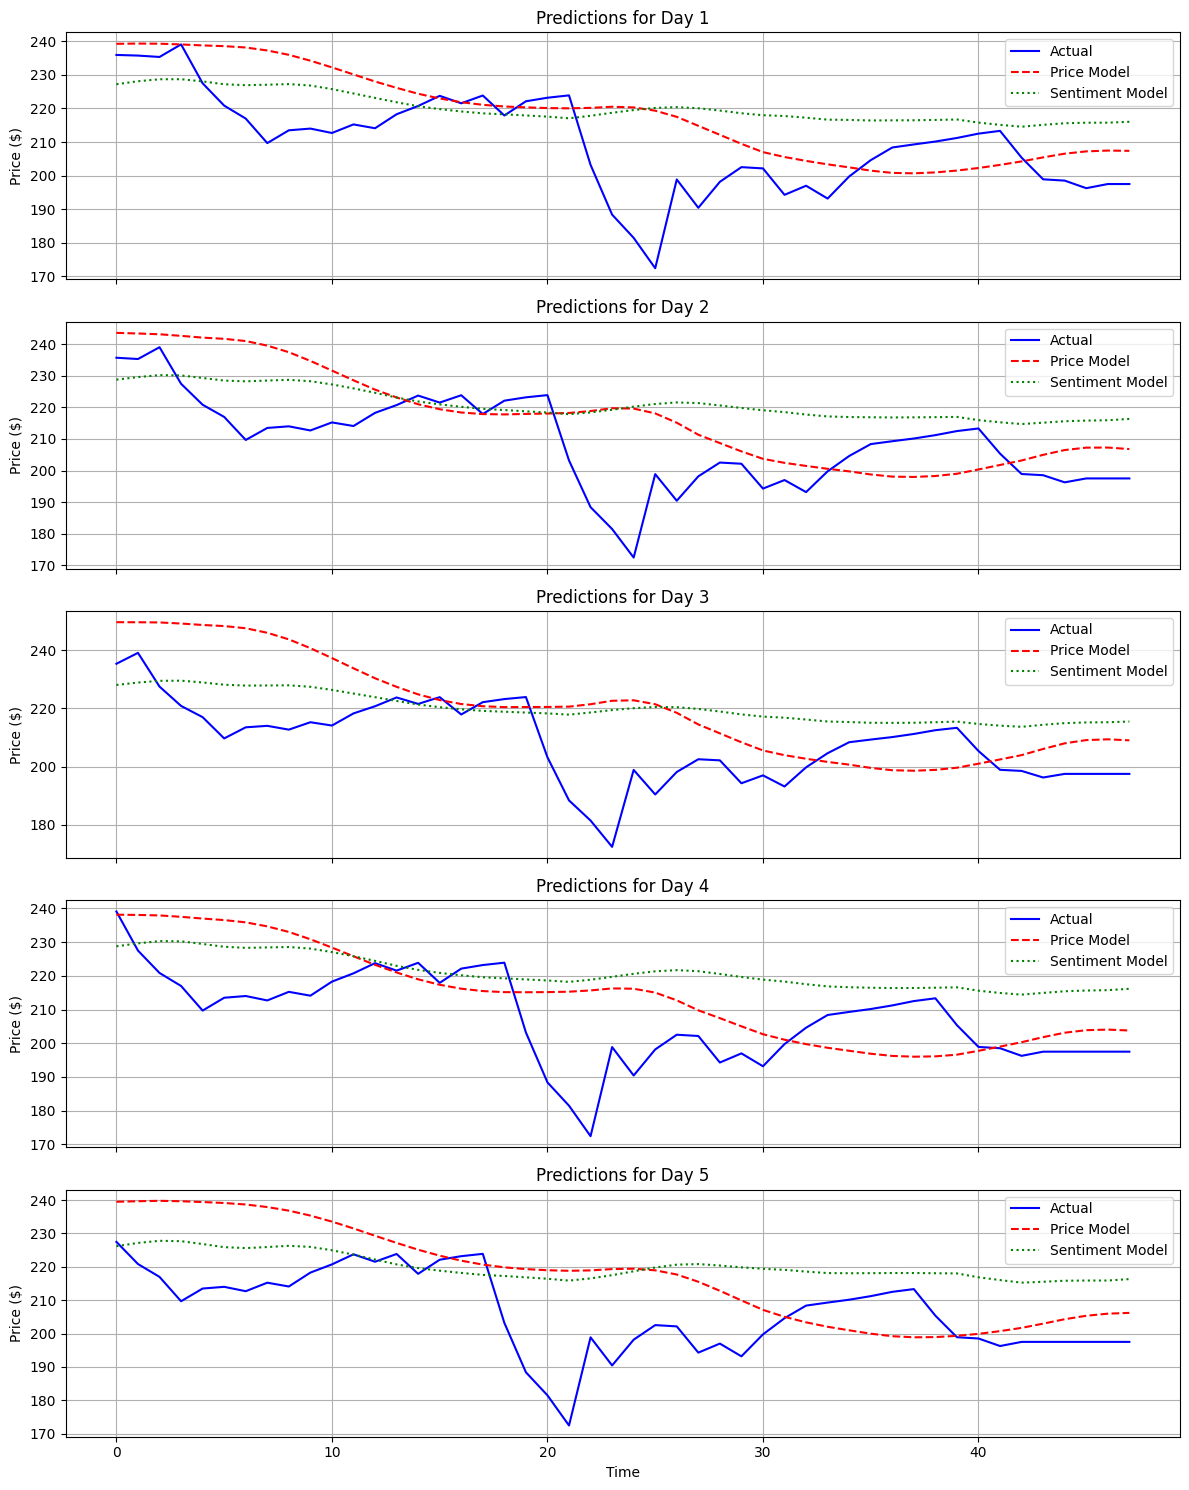

In [645]:
# Plot predictions for each of the 5 days
days = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

for i in range(5):
    axes[i].plot(y_test_actual[:, i], label='Actual', color='blue')
    axes[i].plot(y_test_pred[:, i], label='Price Model', color='red', linestyle='--')
    axes[i].plot(y_test_pred_sentiment[:, i], label='Sentiment Model', color='green', linestyle=':')
    axes[i].set_title(f'Predictions for {days[i]}')
    axes[i].set_ylabel('Price ($)')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()


# Single Day Prediction:
Models trained (price only and sentiment + price) for predicting the stock price for a single day.

In [656]:
np.random.seed(42)
tf.random.set_seed(42)
# Create single-day target
y_single = df['close'].values


# fn to create sequences for LSTM
def create_sequences_single(data, targets, lookback=30):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback):
        X_seq.append(data[i:i+lookback])
        y_seq.append(targets[i+lookback])
    return np.array(X_seq), np.array(y_seq)

# scale the data
scaler_price_single = MinMaxScaler()
scaler_sentiment_single = MinMaxScaler()
scaler_y_single = MinMaxScaler()

# fit the scalers
X_price_scaled_single = scaler_price_single.fit_transform(X_price)
X_sentiment_scaled_single = scaler_sentiment_single.fit_transform(X_sentiment)
y_scaled_single = scaler_y_single.fit_transform(y_single.reshape(-1, 1))

# create sequences
X_price_seqs, y_price_seqs = create_sequences_single(X_price_scaled_single, y_scaled_single, lookback=30)
X_sentiment_seqs, y_sentiment_seqs = create_sequences_single(X_sentiment_scaled_single, y_scaled_single, lookback=30)

# split the data without shuffling (80% train, 20% test)
train_size_prices = int(len(X_price_seqs) * 0.8)
X_price_trains = X_price_seqs[:train_size_prices]
X_price_tests = X_price_seqs[train_size_prices:]
y_price_trains = y_price_seqs[:train_size_prices]
y_price_tests = y_price_seqs[train_size_prices:]

train_size_sentiments = int(len(X_sentiment_seqs) * 0.8)
X_sentiment_trains = X_sentiment_seqs[:train_size_sentiments]
X_sentiment_tests = X_sentiment_seqs[train_size_sentiments:]
y_sentiment_trains = y_sentiment_seqs[:train_size_sentiments]
y_sentiment_tests = y_sentiment_seqs[train_size_sentiments:]


# Model 1: Price only model
model_price_1 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, X_price_trains.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

model_price_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model 2: Including sentiment
model_with_sentiment_1 = Sequential([
    LSTM(32, return_sequences=True, input_shape=(30, X_sentiment_trains.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

model_with_sentiment_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Model 1 (price only)
print("Training price-only model...")
history_price_1 = model_price_1.fit(
    X_price_trains, y_price_trains,
    epochs=150,
    batch_size=32,
    validation_split=0.2,

    verbose=1
)

# Train Model 2 (with sentiment)
print("Training model with sentiment...")
history_sentiment_1 = model_with_sentiment_1.fit(
    X_sentiment_trains, y_sentiment_trains,
    epochs=150,
    batch_size=32,
    validation_split=0.2,

    verbose=1
)

# model evaluation
price_mae_1 = model_price_1.evaluate(X_price_tests, y_price_tests)[1]
sentiment_mae_1 = model_with_sentiment_1.evaluate(X_sentiment_tests, y_sentiment_tests)[1]

print(f"Price-only model MAE: {price_mae_1:.4f}")
print(f"Sentiment model MAE: {sentiment_mae_1:.4f}")


# function to make predctions for the next day
def predict_next_day(model, recent_data, scaler_x, scaler_y):

    scaled_input = scaler_x.transform(recent_data)
    print(scaled_input.shape)

    # reshape to get one prediction
    reshaped_input = scaled_input.reshape(1, 30, scaled_input.shape[1])

    scaled_prediction = model.predict(reshaped_input)

    # inverse transform to get actual price
    prediction = scaler_y.inverse_transform(scaled_prediction)

    return prediction[0][0]

# last 30 days of data for prediction
latest_window_price = X_price[-30:]
latest_window_sentiment = X_sentiment[-30:]

# predictions with both models
price_prediction_1 = predict_next_day(model_price_1, latest_window_price, scaler_price_single, scaler_y_single)
sentiment_prediction_1 = predict_next_day(model_with_sentiment_1, latest_window_sentiment, scaler_sentiment_single, scaler_y_single)

print("\nPredictions for the next day:")
print(f"Price-only model: ${price_prediction_1:.2f}")
print(f"Sentiment model: ${sentiment_prediction_1:.2f}")

Price-only model MAE: 0.0773
Sentiment model MAE: 0.1354
(30, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
(30, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

Predictions for the next day:
Price-only model: $201.46
Sentiment model: $202.42


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


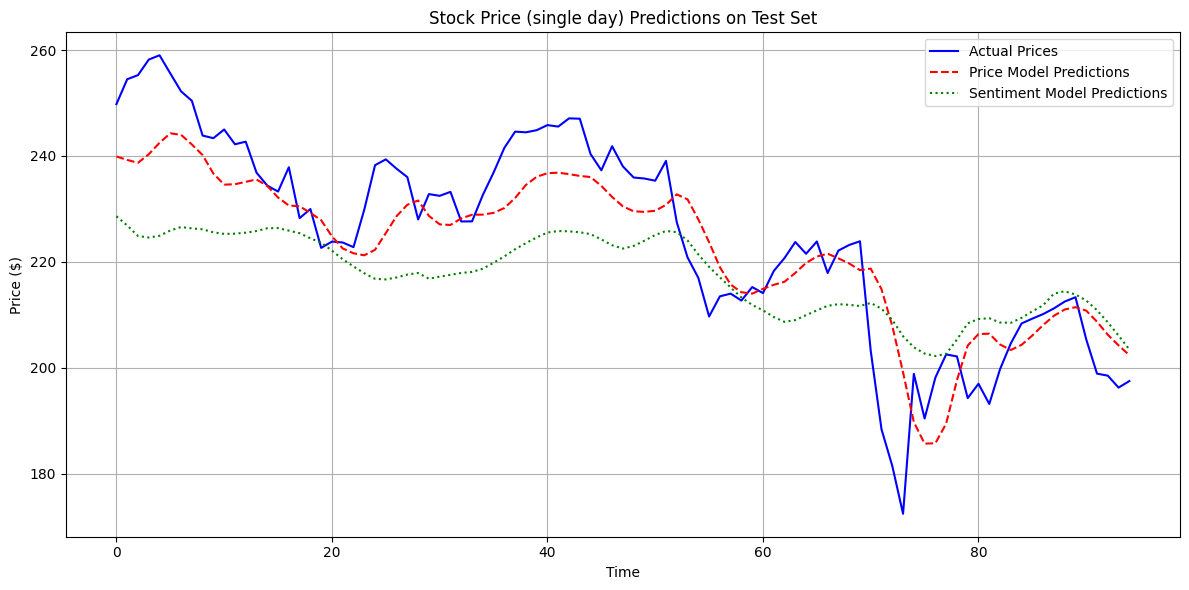

In [655]:
# plot the predictions vs actual values for test set
plt.figure(figsize=(12, 6))
plt.title('Stock Price (single day) Predictions on Test Set')
plt.xlabel('Time')
plt.ylabel('Price ($)')

y_test_actuals = scaler_y_single.inverse_transform(y_price_tests)

# price only model
y_test_preds = model_price_1.predict(X_price_tests)
y_test_preds = scaler_y_single.inverse_transform(y_test_preds)

# sentiment model
y_test_pred_sentiments = model_with_sentiment_1.predict(X_sentiment_tests)
y_test_pred_sentiments = scaler_y_single.inverse_transform(y_test_pred_sentiments)

# Plot actual vs predicted
plt.plot(y_test_actuals, label='Actual Prices', color='blue')
plt.plot(y_test_preds, label='Price Model Predictions', color='red', linestyle='--')
plt.plot(y_test_pred_sentiments, label='Sentiment Model Predictions', color='green', linestyle=':')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

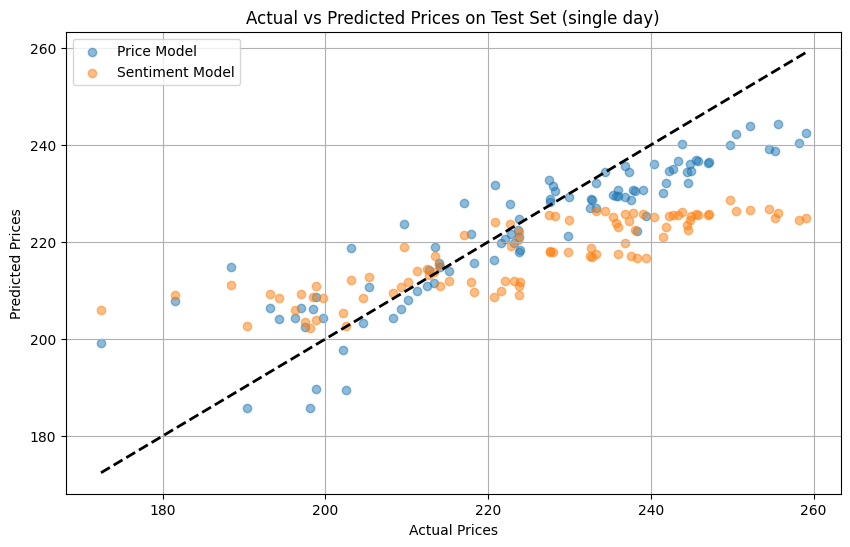

In [654]:
# scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actuals[:, 0], y_test_preds[:, 0], alpha=0.5, label='Price Model')
plt.scatter(y_test_actuals[:, 0], y_test_pred_sentiments[:, 0], alpha=0.5, label='Sentiment Model')

plt.plot([y_test_actuals.min(), y_test_actuals.max()], [y_test_actuals.min(), y_test_actuals.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices on Test Set (single day)')
plt.legend()
plt.grid(True)
plt.show()

In [162]:
import pickle

In [650]:
with open('model_with_sentiment_1.pkl', 'wb') as file:
  pickle.dump(model_with_sentiment_1, file)

In [651]:
with open('model_price_1.pkl', 'wb') as file:
  pickle.dump(model_price_1, file)

In [652]:
# pickle dump scalers for single day prediction
with open('scaler_price_single.pkl', 'wb') as file:
  pickle.dump(scaler_price_single, file)

with open('scaler_sentiment_single.pkl', 'wb') as file:
  pickle.dump(scaler_sentiment_single, file)

with open('scaler_y_single.pkl', 'wb') as file:
  pickle.dump(scaler_y_single, file)


_______________________________________________________________________________________

# Model Testing (in progress)

In [3]:
!pip install finnhub-python

In [74]:
import pandas as pd
import finnhub
from supabase import create_client
import asyncio
import aiohttp
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from concurrent.futures import ThreadPoolExecutor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np

In [11]:
import urllib.request, json
import datetime as dt

In [ ]:
# MAIN FUNCTION
%%writefile main.py
# saves python file in colab as main.py

from load_dotenv import load_dotenv
load_dotenv()

import pandas as pd
import os
import urllib.request, json
import datetime as dt
import finnhub
from supabase import create_client
import asyncio
import aiohttp
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from concurrent.futures import ThreadPoolExecutor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np

url= os.environ.get("SUPABASE_URL")
key= os.environ.get("SUPABASE_KEY")
supabase= create_client(url, key)

API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")
finnhub_api_key = os.getenv("FINNHUB_API_KEY")
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Model and tokenizer (FinBERT) for sentiment analysis
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def get_test_stock_data(symbol):
  url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(symbol, alphavantage_key)
  with urllib.request.urlopen(url_string) as url:
        # read the data from the url
        data = json.loads(url.read().decode())

        # key = "Time Series (Daily)" only needs to be used
        data = data['Time Series (Daily)']

        # create a pandas dataframe with the data
        df = pd.DataFrame.from_dict(data, orient = 'index')
        df.reset_index(inplace = True)
        df.rename(columns={'index': 'date', '1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'}, inplace=True)

        df['date'] = pd.to_datetime(df['date'])

        # get past 30 DAYS data
        thirty_days = dt.datetime.today() - dt.timedelta(days=30)
        df = df[df['date'] > thirty_days]

        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(int)

        # Sort the dataframe by date
        df.sort_values(by='date', ascending=True, inplace=True)

        df['ticker'] = symbol.upper()


        # print(df.head(5))

        return df

def fetch_news_test(symbol):
  to_str = (dt.datetime.now() - dt.timedelta(days=1)).strftime('%Y-%m-%d')
  from_str = (dt.datetime.today() - dt.timedelta(days=31)).strftime('%Y-%m-%d')

  url = f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from={from_str}&to={to_str}&token={finnhub_key}'
  with urllib.request.urlopen(url) as url:
    data = json.loads(url.read().decode())

  news_df = pd.DataFrame(data)
  news_df['ticker'] = symbol.upper()
  news_df['date'] = pd.to_datetime(news_df['datetime'], unit='s').dt.strftime('%Y-%m-%d')
  news_df = news_df[['ticker', 'date', 'headline', 'summary', 'url']]
  news_df.sort_values(by='date', ascending=True, inplace=True)
  news_df.reset_index(drop=True, inplace=True)
  return news_df


def sentiment_analysis_test(news_df):
  texts = (news_df['headline'].fillna('') + '. ' + news_df['summary'].fillna('')).tolist()
  sentiments = sentiment_pipeline(texts, padding = True, truncation=True, batch_size=16)
  scores = [
      r['score'] if r['label'] == 'positive' else -r['score']
      for r in sentiments
  ]
  return scores


In [15]:
def get_test_stock_data(symbol):
  url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(symbol, alphavantage_key)
  with urllib.request.urlopen(url_string) as url:
        # read the data from the url
        data = json.loads(url.read().decode())

        # key = "Time Series (Daily)" only needs to be used
        data = data['Time Series (Daily)']

        # create a pandas dataframe with the data
        df = pd.DataFrame.from_dict(data, orient = 'index')
        df.reset_index(inplace = True)
        df.rename(columns={'index': 'date', '1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'}, inplace=True)


        df['date'] = pd.to_datetime(df['date'])

        # get only past 30 DAYS data
        thirty_days = dt.datetime.today() - dt.timedelta(days=30)
        df = df[df['date'] > thirty_days]

        # convert rest of the columns to the appropriate data types
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(int)

        # Sort the dataframe by date
        df.sort_values(by='date', ascending=True, inplace=True)

        df['ticker'] = symbol.upper()


        # print(df.head(5))

        return df

In [16]:
stock_df = get_test_stock_data('AAPL')

In [18]:
stock_df.tail(10)

,date,open,high,low,close,volume,ticker
9,2025-04-25,206.365,209.75,206.2000,209.28,38222258,AAPL
8,2025-04-28,210.000,211.50,207.4600,210.14,38743074,AAPL
7,2025-04-29,208.693,212.24,208.3700,211.21,36827633,AAPL
6,2025-04-30,209.300,213.58,206.6705,212.50,52286454,AAPL
5,2025-05-01,209.080,214.56,208.9000,213.32,57365675,AAPL
4,2025-05-02,206.090,206.99,202.1600,205.35,101010621,AAPL
3,2025-05-05,203.100,204.10,198.2100,198.89,69018452,AAPL
2,2025-05-06,198.210,200.65,197.0200,198.51,51216482,AAPL
1,2025-05-07,199.170,199.44,193.2500,196.25,68616943,AAPL
0,2025-05-08,197.720,200.05,194.6796,197.49,49072967,AAPL


In [365]:
stock_df.shape

(21, 7)

In [30]:
import os
import datetime
import pytz

os.environ['TZ'] = 'America/Los_Angeles'
dt.datetime.now(pytz.timezone(os.environ['TZ'])).strftime('%Y-%m-%d')

'2025-05-08'

In [83]:
def fetch_news_test(symbol):
  to_str = (dt.datetime.now() - dt.timedelta(days=1)).strftime('%Y-%m-%d')
  from_str = (dt.datetime.today() - dt.timedelta(days=31)).strftime('%Y-%m-%d')

  url = f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from={from_str}&to={to_str}&token={finnhub_key}'
  with urllib.request.urlopen(url) as url:
    data = json.loads(url.read().decode())

  news_df = pd.DataFrame(data)
  news_df['ticker'] = symbol.upper()
  news_df['date'] = pd.to_datetime(news_df['datetime'], unit='s').dt.strftime('%Y-%m-%d')
  news_df = news_df[['ticker', 'date', 'headline', 'summary', 'url']]
  news_df.sort_values(by='date', ascending=True, inplace=True)
  news_df.reset_index(drop=True, inplace=True)
  return news_df



In [193]:
import asyncio
import aiohttp
import nest_asyncio

# Apply nest_asyncio patch for Jupyter notebooks
nest_asyncio.apply()

In [342]:
# function to fetch news for a date chunk asynchronously
async def fetch_news_chunk_test(session, symbol, from_str, to_str):

    url = f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from={from_str}&to={to_str}&token={finnhub_key}'
    try:
        async with session.get(url, timeout=10) as response:
            if response.status == 200:
                return await response.json()
            print(f"Error {response.status} for {from_str} to {to_str} for {symbol}")
            return []
    except Exception as e:
        print(f"Request failed: {str(e)}")
        return []

# function that calls fetch_news_chunk asynchronously
async def fetch_30_days_test(session, symbol):

    end_date = dt.datetime.today()
    start_date = end_date - dt.timedelta(days=30)
    all_articles = []


    # Generate date chunks
    current_start = start_date
    while current_start <= end_date:
        current_end = min(current_start + dt.timedelta(days=5), end_date)
        from_str = current_start.strftime('%Y-%m-%d')
        to_str = current_end.strftime('%Y-%m-%d')
        # date_chunks.append((from_str, to_str))

        chunk = await fetch_news_chunk_test(session, symbol, from_str, to_str)

        if isinstance(chunk, list):
            all_articles.extend(chunk)
            print(f"{symbol}: Got {len(chunk)} articles from {from_str} to {to_str}")
            if len(chunk) >= 1000:
                print(f"Warning: Possible data truncation in chunk")

        current_start = current_end + dt.timedelta(days=1)

    df = pd.DataFrame(all_articles).drop_duplicates('id')
    df['datetime'] = pd.to_datetime(df['datetime'], unit='s', errors='coerce')
    df = df.dropna(subset=['datetime'])
    df = df[df['datetime'].between('1970-01-01', '2262-04-11')]
    df['ticker'] = symbol.upper()
    df['date'] = pd.to_datetime(df['datetime']).dt.date
    # df = df.groupby(['ticker', 'date']).head(10).reset_index(drop=True)
    # print(df.head(3))
    # print(df.iloc[0]['headline'])
    df = df[['ticker', 'id', 'datetime', 'headline', 'url', 'summary']].sort_values('datetime')
    return df

In [344]:
async def main(symbol):

  async with aiohttp.ClientSession() as session:
    news_df = await fetch_30_days_test(session, symbol)
    return news_df


symbol = 'AAPL'
news = asyncio.run(main(symbol))
print(news.head())

AAPL: Got 235 articles from 2025-04-08 to 2025-04-13
AAPL: Got 205 articles from 2025-04-14 to 2025-04-19
AAPL: Got 202 articles from 2025-04-20 to 2025-04-25
AAPL: Got 208 articles from 2025-04-26 to 2025-05-01
AAPL: Got 229 articles from 2025-05-02 to 2025-05-07
AAPL: Got 46 articles from 2025-05-08 to 2025-05-08
    ticker         id            datetime  \
216   AAPL  133775038 2025-04-08 12:21:49   
234   AAPL  133797370 2025-04-08 16:48:47   
233   AAPL  133823010 2025-04-08 17:59:00   
232   AAPL  133798698 2025-04-08 18:00:00   
231   AAPL  133801761 2025-04-08 18:00:00   

                                              headline  \
216  US Stock Futures Soar as Dip Buyers Emerge Aft...   
234  Apple: A Contrarian Buy Opportunity (Rating Up...   
233  Trump’s team thinks Apple’s iPhones should be ...   
232  Apple Stock Suffers Sharp Selloff: Buy the Dip...   
231  Building A $100,000 Dividend Portfolio: Enhanc...   

                                                   url  \
216  

In [84]:
april_news = fetch_news_test('AAPL')

In [87]:
april_news.tail(5)

,ticker,date,headline,summary,url
173,AAPL,2025-04-30,EU Fines Apple And Meta €700m For Non-complian...,"On 23 April 2025, the European Commission issu...",https://finnhub.io/api/news?id=13c1553d7071a9b...
174,AAPL,2025-04-30,Prediction: 1 Stock That'll Be Worth More Than...,Apple is the world's largest company by market...,https://finnhub.io/api/news?id=4cbbe989904989d...
175,AAPL,2025-04-30,The Davenport Core Leaders Fund Q1 2025 Commen...,The Davenport Core Leaders Fund declined 3.48%...,https://finnhub.io/api/news?id=30cbbdae87c9b1b...
176,AAPL,2025-04-30,"As Apple reports earnings, here’s why $200 is ...","As Apple reports earnings, here’s why $200 is ...",https://finnhub.io/api/news?id=8c45bfd913931ab...
177,AAPL,2025-04-30,Franklin Global Equity Fund Q1 2025 Commentary,Stock selection was mixed at the region and se...,https://finnhub.io/api/news?id=add304a3ab757e7...


In [69]:
news = fetch_news_test('AAPL')

In [345]:


news.head(5)

,ticker,id,datetime,headline,url,summary
216,AAPL,133775038,2025-04-08 12:21:49,US Stock Futures Soar as Dip Buyers Emerge Aft...,https://finnhub.io/api/news?id=a66a1986818f3d5...,(Bloomberg) -- US stocks rallied in premarket ...
234,AAPL,133797370,2025-04-08 16:48:47,Apple: A Contrarian Buy Opportunity (Rating Up...,https://finnhub.io/api/news?id=a49a905d6607d9b...,"Apple Inc. stock dropped 19%, reaching oversol..."
233,AAPL,133823010,2025-04-08 17:59:00,Trump’s team thinks Apple’s iPhones should be ...,https://finnhub.io/api/news?id=e5df509c4d82e5d...,Trump’s team thinks Apple’s iPhones should be ...
232,AAPL,133798698,2025-04-08 18:00:00,Apple Stock Suffers Sharp Selloff: Buy the Dip...,https://finnhub.io/api/news?id=6046f5a06320183...,Apple shares are experiencing a massive market...
231,AAPL,133801761,2025-04-08 18:00:00,"Building A $100,000 Dividend Portfolio: Enhanc...",https://finnhub.io/api/news?id=306a992842aae5d...,Enhance your dividend strategy with April 2025...


In [75]:
# Model and tokenizer (FinBERT) for sentiment analysis
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


In [77]:
def sentiment_analysis_test(news_df):
  texts = (news_df['headline'].fillna('') + '. ' + news_df['summary'].fillna('')).tolist()
  sentiments = sentiment_pipeline(texts, padding = True, truncation=True, batch_size=16)
  scores = [
      r['score'] if r['label'] == 'positive' else -r['score']
      for r in sentiments
  ]
  return scores


In [346]:

scores = sentiment_analysis_test(news)


In [347]:
len(scores)

1124

In [399]:
news['sentiment_score'] = scores
news['date'] = pd.to_datetime(news['datetime']).dt.date
daily_sentiment_test = news.groupby(['date', 'ticker'])['sentiment_score'].mean().reset_index()
daily_sentiment_test['num_articles'] = news.groupby(['ticker', 'date'])['date'].count().values
stock_df['date'] = pd.to_datetime(stock_df['date']).dt.date

# merge stock prices with daily average sentiment
test_df = pd.merge(stock_df, daily_sentiment_test, on=['ticker', 'date'], how='left')
test_df.rename(columns= {"sentiment_score" :"avg_sentiment"}, inplace=True)

test_df['avg_sentiment']= test_df['avg_sentiment'].fillna(0.0)  # Fill missing sentiment as neutral
test_df['num_articles'] = test_df['num_articles'].fillna(0)



# Adding more features related to sentiment (lagged sentiment, moving averages, etc.)
test_df['sentiment_ma3'] = test_df['avg_sentiment'].rolling(window=3).mean()
test_df['sentiment_lag1'] = test_df['avg_sentiment'].shift(1)
test_df['log_article_count'] = np.log(test_df['num_articles'] + 1)
test_df['sentiment_volatility'] = test_df['avg_sentiment'].rolling(window=7).std()
test_df['sentiment_close_corr'] = test_df['avg_sentiment'].rolling(5).corr(test_df['close'])

test_df.head(5)

,date,open,high,low,close,volume,ticker,avg_sentiment,num_articles,sentiment_ma3,sentiment_lag1,log_article_count,sentiment_volatility,sentiment_close_corr
0,2025-04-09,171.950,200.6100,171.8900,198.85,184395885,AAPL,-0.352990,73,NaN,NaN,4.304065,NaN,NaN
1,2025-04-10,189.065,194.7799,183.0000,190.42,121879981,AAPL,-0.584342,57,NaN,-0.352990,4.060443,NaN,NaN
2,2025-04-11,186.100,199.5400,186.0600,198.15,87435915,AAPL,-0.404420,38,-0.447251,-0.584342,3.663562,NaN,NaN
3,2025-04-14,211.440,212.9400,201.1621,202.52,101352911,AAPL,-0.032689,77,-0.340484,-0.404420,4.356709,NaN,NaN
4,2025-04-15,201.855,203.5100,199.8000,202.14,51343872,AAPL,-0.125463,44,-0.187524,-0.032689,3.806662,NaN,0.932186


In [393]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  21 non-null     object 
 1   open                  21 non-null     float64
 2   high                  21 non-null     float64
 3   low                   21 non-null     float64
 4   close                 21 non-null     float64
 5   volume                21 non-null     int64  
 6   ticker                21 non-null     object 
 7   avg_sentiment         21 non-null     float64
 8   num_articles          21 non-null     int64  
 9   sentiment_ma3         19 non-null     float64
 10  sentiment_lag1        20 non-null     float64
 11  log_article_count     21 non-null     float64
 12  sentiment_volatility  15 non-null     float64
 13  sentiment_close_corr  17 non-null     float64
dtypes: float64(10), int64(2), object(2)
memory usage: 2.4+ KB


In [387]:
daily_sentiment_test.shape

(31, 4)

In [400]:
# create a day and month column
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
# Adding a flag to check if there is a sentiment score or not
# based on the number of news articles, set the flag
test_df['has_sentiment'] = test_df['num_articles'].apply(lambda x: 1 if x>0 else 0)

In [401]:
test_df_price = test_df.drop(columns=['date','avg_sentiment', 'sentiment_ma3', 'sentiment_lag1', 'log_article_count', 'sentiment_volatility', 'sentiment_close_corr', 'has_sentiment'])
test_df_sentiment = test_df.drop(columns=['date','open', 'high', 'low', 'close', 'volume', 'day', 'month'])

In [ ]:
# load model from pkl file
with open('/content/drive/MyDrive/model_price_1.pkl', 'rb') as file:
  model_price = pickle.load(file)

with open('/content/drive/MyDrive/model_with_sentiment_1.pkl', 'rb') as file:
  model_sentiment = pickle.load(file)

test_df_price = test_df_price.values
test_df_sentiment = test_df_sentiment.values


In [445]:
# Function to make predictions for the next 5 days
def predict_next_5_days_test(model, recent_data, scaler_x, scaler_y):

    scaled_input = scaler_x.transform(recent_data)

    reshaped_input = scaled_input.reshape(1, 21, scaled_input.shape[1])

    # Make prediction
    scaled_prediction = model.predict(reshaped_input)

    # Inverse transform to get actual prices
    prediction = scaler_y.inverse_transform(scaled_prediction)

    return prediction

In [ ]:
# predict prices for next days
price_prediction = predict_next_5_days_test(model_price, test_df_price, scaler_price, scaler_y_single)
sentiment_price_prediction = predict_next_5_days_test(model_sentiment, test_df_sentiment, scaler_sentiment, scaler_y_single)

# print the results
for i in range(1):
  print(f"Day {i+1}: Price Prediction = {price_prediction[i][0]} ----|---- Sentiment Prediction = {sentiment_price_prediction[i][0]}")

In [ ]:
# Define features for both models
price_features = ['open', 'high', 'low', 'close', 'volume', 'day', 'month']
sentiment_features = ['avg_sentiment', 'sentiment_ma3', 'sentiment_lag1', 'log_article_count', 'sentiment_volatility', 'has_sentiment']

# Create datasets
test_df_price = test_df[price_features].values
test_df_sentiment = test_df[price_features + sentiment_features].values

# scale the data
test_df_price_scaled = scaler_price.transform(test_df_price)
test_df_sentiment_scaled = scaler_sentiment.transform(test_df_sentiment)

# create sequences for LSTM
def create_sequences(data, lookback=21):
    X_seq = []
    for i in range(len(data) - lookback + 1):
        X_seq.append(data[i:i + lookback])
    return np.array(X_seq)

# sequences for the price only model
test_df_price_seq = create_sequences(test_df_price_scaled, lookback=21)

# sequences for the sentiment model
test_df_sentiment_seq = create_sequences(test_df_sentiment_scaled, lookback=21)

# predict prices for next days
price_prediction = predict_next_5_days_test(model_price, test_df_price, scaler_price, scaler_y_single)
sentiment_price_prediction = predict_next_5_days_test(model_sentiment, test_df_sentiment, scaler_sentiment, scaler_y_single)

price_prediction = scaler_y_single.inverse_transform(price_prediction)
sentiment_price_prediction = scaler_y_single.inverse_transform(sentiment_price_prediction)

# print the results
for i in range(len(price_prediction)):
    print(f"Day {i+1}: Price Prediction = {price_prediction[i][0]:.2f} ----|---- Sentiment Prediction = {sentiment_price_prediction[i][0]:.2f}")

In [423]:
test_df_price_seq.shape

(2, 20, 7)